In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import keras
from keras.models import *
from keras.layers import *
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

/hdd/home/superdanby/.conda/envs/yee/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_ROOT = '/hdd/dataset/tbrain/'
TRAIN_PATH = os.path.join(DATASET_ROOT, 'taetfp_utf8.csv')
TS_IN=30
TS_OUT=5
fields = ['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交張數(張)']

,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,50,20130102,元大台灣50,46.57,47.13,46.49,46.92,16487.0
5228,54,20130102,元大台商50,16.84,16.84,16.54,16.75,20.0
7842,56,20130102,元大高股息,18.45,18.63,18.45,18.55,1623.0
9149,57,20130102,富邦摩台,30.35,30.69,30.35,30.69,69.0
3921,53,20130102,元大電子,19.84,19.84,19.52,19.81,42.0
10456,58,20130102,富邦發達,32.45,32.45,32.12,32.12,2.0
11763,59,20130102,富邦金融,24.65,24.65,24.65,24.65,2.0
2614,52,20130102,富邦科技,26.57,26.95,26.57,26.92,26.0
13070,6201,20130102,元大富櫃50,9.08,9.18,9.01,9.13,254.0
14377,6203,20130102,元大MSCI台灣,22.61,22.61,22.56,22.56,28.0


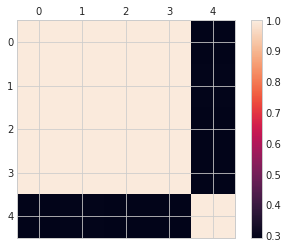

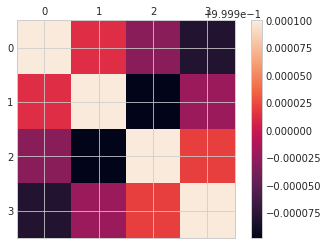

In [3]:
train_csv = pd.read_csv(TRAIN_PATH)
train_csv.sort_values(by=['日期'], ascending=True, inplace=True)
train_csv[fields] = train_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(train_csv.head(n=10))
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[fields].corr())
fig.colorbar(cax)
plt.show()
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)']].corr())
fig.colorbar(cax)
plt.show()

In [4]:
codes = list(sorted(set(train_csv['代碼'])))

Simple EDA on (code 50)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.00000,1307.000000
mean,62.089464,62.355142,61.806687,62.09798,9149.658761
std,10.785697,10.805576,10.763992,10.79194,7158.670288
min,45.970000,46.140000,45.670000,45.71000,809.000000
25%,53.670000,54.155000,53.520000,53.87000,4106.000000
50%,59.830000,60.070000,59.500000,59.81000,7088.000000
75%,68.500000,68.730000,68.330000,68.54000,11875.000000
max,85.840000,86.180000,85.690000,86.08000,61317.000000


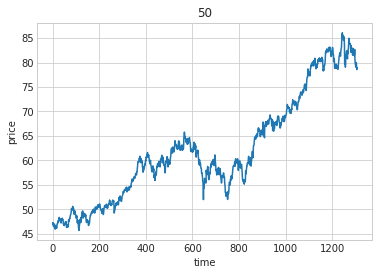

Simple EDA on (code 51)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,26.324805,26.437988,26.192119,26.300260,47.320581
std,2.684661,2.681309,2.687309,2.680824,76.016716
min,20.610000,21.170000,20.380000,20.380000,0.000000
25%,24.300000,24.360000,24.130000,24.235000,14.000000
50%,26.230000,26.330000,26.100000,26.220000,27.000000
75%,27.680000,27.785000,27.560000,27.600000,49.000000
max,33.150000,33.210000,33.020000,33.180000,1061.000000


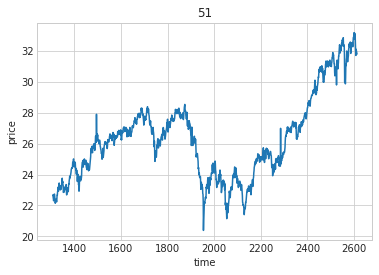

Simple EDA on (code 52)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,37.169969,37.289112,37.024415,37.143183,13.850803
std,8.174995,8.194198,8.140942,8.167300,30.184653
min,25.970000,25.980000,25.970000,25.980000,0.000000
25%,31.035000,31.175000,30.720000,31.035000,2.000000
50%,35.490000,35.610000,35.240000,35.400000,5.000000
75%,41.115000,41.150000,40.965000,41.030000,12.000000
max,57.880000,58.070000,56.860000,57.540000,394.000000


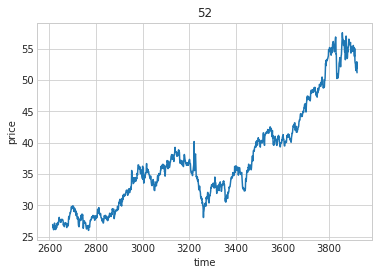

Simple EDA on (code 53)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,26.710406,26.808768,26.595295,26.698646,38.573068
std,5.152289,5.142645,5.145575,5.134227,101.959206
min,19.140000,19.270000,18.140000,19.130000,0.000000
25%,23.040000,23.170000,22.935000,23.020000,8.000000
50%,25.800000,25.860000,25.640000,25.770000,17.000000
75%,29.255000,29.360000,29.155000,29.290000,42.000000
max,38.030000,38.030000,37.840000,37.860000,2866.000000


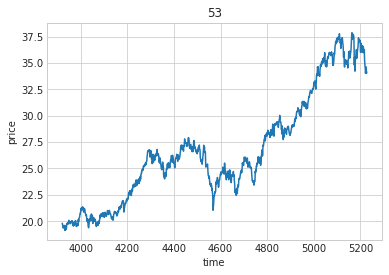

Simple EDA on (code 54)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,20.439893,20.511622,20.357353,20.438064,25.115532
std,2.355723,2.346377,2.368945,2.349442,42.828226
min,16.030000,16.140000,15.920000,16.100000,0.000000
25%,18.780000,18.840000,18.695000,18.770000,5.000000
50%,20.320000,20.420000,20.240000,20.320000,12.000000
75%,21.825000,21.900000,21.770000,21.840000,29.000000
max,25.490000,25.540000,25.420000,25.490000,568.000000


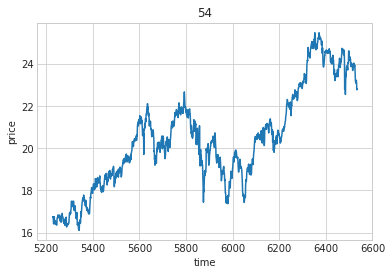

Simple EDA on (code 55)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,13.246014,13.308240,13.184981,13.246182,783.591431
std,1.712246,1.713001,1.708972,1.708292,1288.915204
min,9.820000,9.870000,9.760000,9.800000,2.000000
25%,11.920000,11.970000,11.875000,11.920000,122.500000
50%,13.120000,13.170000,13.060000,13.120000,370.000000
75%,14.485000,14.550000,14.460000,14.480000,929.500000
max,17.200000,17.220000,17.150000,17.200000,15113.000000


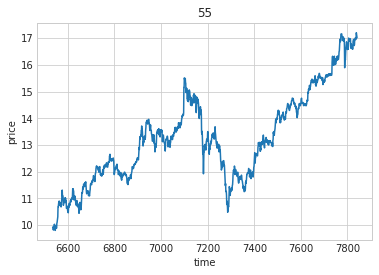

Simple EDA on (code 56)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,21.411064,21.484338,21.319587,21.408179,1927.348125
std,2.265922,2.268580,2.273911,2.271817,2072.866913
min,17.130000,17.200000,16.400000,17.050000,123.000000
25%,19.490000,19.555000,19.400000,19.510000,687.500000
50%,20.840000,20.900000,20.760000,20.840000,1252.000000
75%,22.860000,22.870000,22.755000,22.845000,2428.500000
max,26.760000,26.800000,26.570000,26.800000,18605.000000


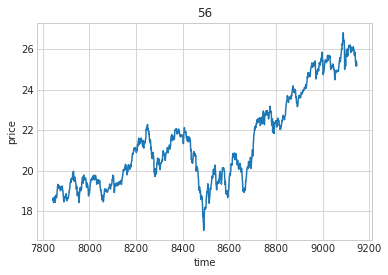

Simple EDA on (code 57)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,39.486297,39.570069,39.392892,39.479977,59.773527
std,5.899813,5.879175,5.904750,5.888137,141.309840
min,29.930000,29.960000,29.930000,29.960000,0.000000
25%,34.785000,34.830000,34.730000,34.790000,3.000000
50%,38.610000,38.740000,38.430000,38.580000,10.000000
75%,42.660000,42.725000,42.625000,42.635000,53.000000
max,52.900000,52.900000,52.900000,52.900000,1893.000000


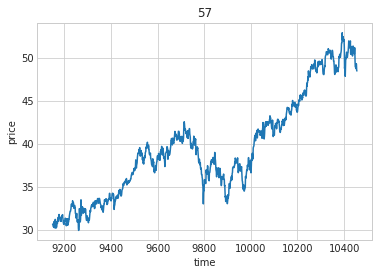

Simple EDA on (code 58)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,38.543397,38.586526,38.494675,38.538018,7.361132
std,4.598829,4.595955,4.597551,4.591754,20.575405
min,30.630000,30.750000,30.630000,30.750000,0.000000
25%,35.095000,35.110000,35.030000,35.090000,0.000000
50%,37.740000,37.830000,37.730000,37.770000,2.000000
75%,40.510000,40.565000,40.440000,40.530000,5.000000
max,48.730000,48.900000,48.730000,48.800000,426.000000


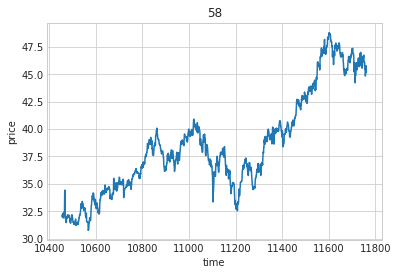

Simple EDA on (code 59)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,32.767322,32.857490,32.669579,32.754185,13.521806
std,4.030443,4.053468,4.002721,4.014035,33.348502
min,24.360000,24.400000,24.360000,24.360000,0.000000
25%,29.740000,29.770000,29.695000,29.730000,2.000000
50%,32.590000,32.680000,32.530000,32.580000,4.000000
75%,35.190000,35.295000,35.080000,35.180000,12.000000
max,42.500000,42.500000,42.390000,42.500000,504.000000


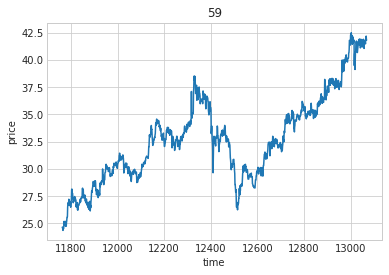

Simple EDA on (code 690)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,269.000000,269.000000,269.000000,269.000000,269.000000
mean,20.824572,20.880446,20.752528,20.818030,694.892193
std,0.970134,0.978990,0.950231,0.961581,386.353464
min,18.720000,18.800000,18.710000,18.780000,20.000000
25%,20.180000,20.280000,20.140000,20.240000,517.000000
50%,20.850000,20.920000,20.790000,20.830000,666.000000
75%,21.650000,21.680000,21.480000,21.540000,864.000000
max,22.520000,22.540000,22.400000,22.480000,2891.000000


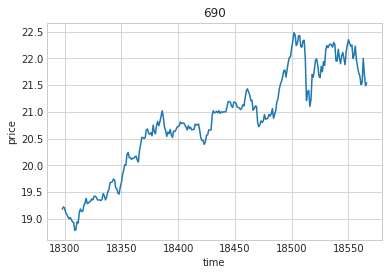

Simple EDA on (code 692)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,239.000000,239.000000,239.000000,239.000000,239.000000
mean,20.658201,20.718285,20.583975,20.657992,1369.635983
std,0.821163,0.824610,0.797484,0.810186,1225.970830
min,18.750000,18.810000,18.660000,18.780000,411.000000
25%,20.210000,20.255000,20.155000,20.210000,883.500000
50%,20.680000,20.750000,20.600000,20.700000,1084.000000
75%,21.295000,21.350000,21.140000,21.250000,1419.500000
max,22.200000,22.290000,22.150000,22.250000,14039.000000


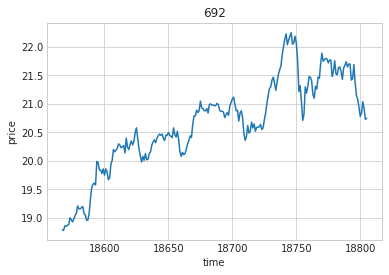

Simple EDA on (code 701)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,174.000000,174.000000,174.000000,174.000000,174.000000
mean,20.525862,20.580172,20.441667,20.505172,517.436782
std,0.542831,0.547172,0.497365,0.506267,1446.224770
min,19.700000,19.720000,19.630000,19.670000,4.000000
25%,20.050000,20.122500,20.000000,20.072500,62.750000
50%,20.335000,20.405000,20.290000,20.330000,143.500000
75%,20.937500,21.022500,20.897500,20.937500,420.250000
max,22.500000,22.500000,21.480000,21.500000,13660.000000


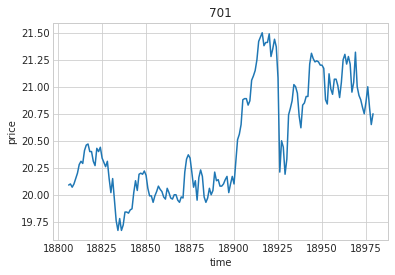

Simple EDA on (code 713)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,145.000000,145.000000,145.000000,145.000000,145.000000
mean,30.583862,30.661034,30.473724,30.563379,567.524138
std,0.390015,0.358670,0.396519,0.364042,1131.224988
min,29.230000,29.900000,29.230000,29.790000,2.000000
25%,30.330000,30.440000,30.190000,30.300000,24.000000
50%,30.640000,30.690000,30.570000,30.610000,80.000000
75%,30.840000,30.920000,30.740000,30.840000,346.000000
max,31.500000,31.500000,31.270000,31.300000,5432.000000


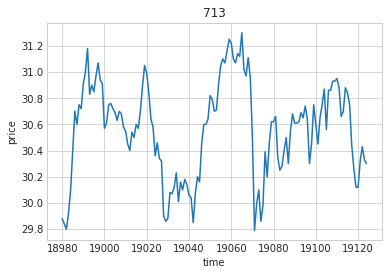

Simple EDA on (code 6201)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,11.472318,11.533581,11.397536,11.459518,75.377965
std,1.347550,1.351618,1.340661,1.341919,116.025830
min,8.690000,9.070000,8.630000,8.640000,0.000000
25%,10.600000,10.660000,10.530000,10.580000,23.000000
50%,11.130000,11.160000,11.030000,11.090000,46.000000
75%,12.040000,12.095000,11.980000,12.030000,89.000000
max,16.220000,16.220000,15.040000,15.150000,1602.000000


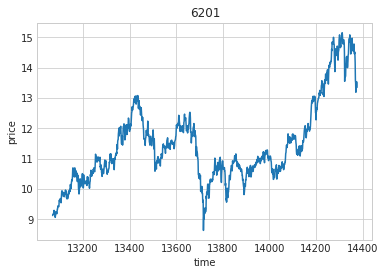

Simple EDA on (code 6203)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,29.519319,29.581844,29.457246,29.523152,242.397093
std,4.619262,4.606099,4.628229,4.614499,8024.657577
min,22.300000,22.300000,22.300000,22.300000,0.000000
25%,26.045000,26.180000,25.855000,26.060000,1.000000
50%,28.760000,28.860000,28.600000,28.730000,3.000000
75%,31.930000,31.935000,31.925000,31.930000,15.000000
max,40.200000,40.200000,40.030000,40.030000,290124.000000


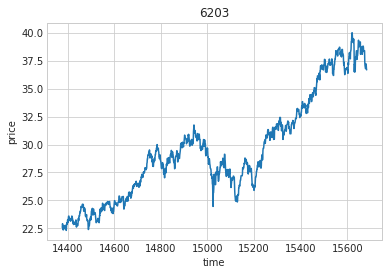

Simple EDA on (code 6204)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,42.386052,42.461890,42.297314,42.382028,193.449120
std,5.805375,5.771369,5.844431,5.806056,520.229453
min,33.320000,33.430000,33.000000,33.050000,0.000000
25%,38.045000,38.190000,37.925000,38.055000,2.000000
50%,41.160000,41.240000,40.990000,41.110000,9.000000
75%,44.780000,44.870000,44.780000,44.780000,152.500000
max,55.700000,55.750000,55.700000,55.700000,7868.000000


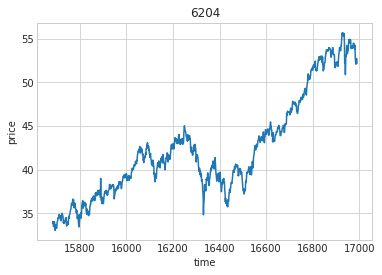

Simple EDA on (code 6208)


,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,35.844009,35.925532,35.746259,35.818959,15.713083
std,6.316084,6.329060,6.317169,6.325125,34.031980
min,26.720000,26.790000,26.560000,26.580000,0.000000
25%,30.980000,31.015000,30.850000,30.895000,1.000000
50%,34.480000,34.530000,34.390000,34.450000,4.000000
75%,39.000000,39.050000,38.995000,39.005000,15.000000
max,50.250000,51.120000,49.770000,51.120000,617.000000


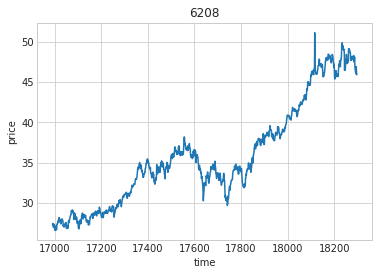

In [5]:
split_train = []
for code in codes:
    row = train_csv.loc[train_csv['代碼']==code][fields]
    print('Simple EDA on (code {:d})'.format(code))
    display(row.describe())
    fit, ax = plt.subplots()
    ax.set_title(str(code))
    ax.set_xlabel('time')
    ax.set_ylabel('price')
    ax.plot(row['收盤價(元)'])
    plt.show()
    split_train.append(np.array(row))

In [6]:
for n, s in enumerate(split_train):
    print(codes[n], len(s))

50 1307
51 1307
52 1307
53 1307
54 1307
55 1307
56 1307
57 1307
58 1307
59 1307
690 269
692 239
701 174
713 145
6201 1307
6203 1307
6204 1307
6208 1307


In [7]:
from keras.regularizers import *

# custom R2-score metrics for keras backend
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def make_model(ts_in=60, ts_out=5, n_field=5, n_encode=128, n_decode=128, reg_a=0.1):
    input_ = Input(shape=(ts_in, n_field))
    lstm_1 = CuDNNLSTM(n_encode, return_sequences=False, recurrent_regularizer=l2(reg_a)) (input_)
    rep_vec_2 = RepeatVector(ts_out) (lstm_1)
    lstm_3 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (rep_vec_2)
    lstm_4 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (lstm_3)
    fc_4 = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a))) (lstm_4)
    return Model([input_], [fc_4])
make_model(ts_in=TS_IN, ts_out=TS_OUT).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 5)             0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               69120     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 128)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 5, 128)            132096    
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 5, 128)            132096    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              129       
Total params: 333,441
Trainable params: 333,441
Non-trainable params: 0
_________________________________________________________________


In [8]:
def make_seq(seq, ts_in=60, ts_out=5):
    Xs = []
    Ys = []
    total_l = ts_in + ts_out
    for i in range(0, len(seq)-total_l+1):
        Xs.append(seq[i:i+ts_in])
        Ys.append(seq[i+ts_in:i+total_l, 3:4])
    return np.array(Xs), np.array(Ys)

In [9]:
train_18 = []
for seq in split_train:
    Xs, Ys = make_seq(seq, ts_in=TS_IN, ts_out=TS_OUT)
    train_18.append([Xs, Ys])

In [10]:
from matplotlib.figure import figaspect
def vis(history, title='no title', dpi=80):
    fig, ax = plt.subplots(1, 3, dpi=80, figsize=(20, 5))
    ax[0].set_title(title+' loss plot')
    ax[1].set_title(title+' loss plot (zoom)')
    ax[2].set_title(title+' r2 plot')
    ax[0].set_xlabel('epoch')
    ax[1].set_xlabel('epoch')
    ax[2].set_xlabel('epoch')
    ax[0].set_ylabel('mse')
    ax[1].set_ylabel('mse')
    ax[2].set_ylabel('r2')
    ax[0].set_ylim(0, 180)
    ax[1].set_ylim(0, 20)
    ax[2].set_ylim(-2, 1)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['train','valid'], loc='upper right')
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].legend(['train','valid'], loc='upper right')
    ax[2].plot(history.history['r2_keras'])
    ax[2].plot(history.history['val_r2_keras'])
    ax[2].legend(['train','valid'], loc='lower right')
    plt.tight_layout()
    plt.show()

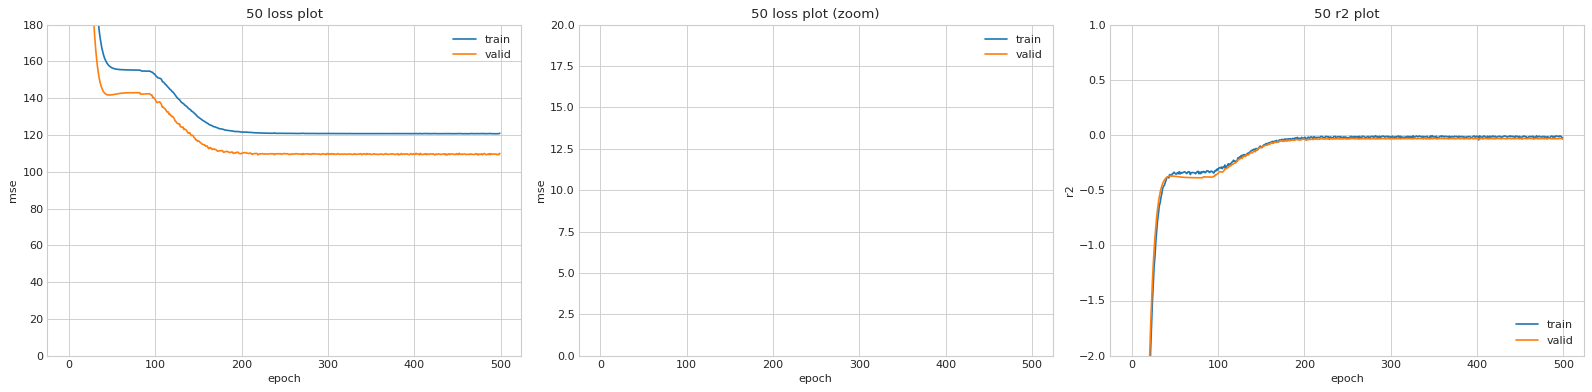

validation loss: 110.027183
validation r2: -0.037397


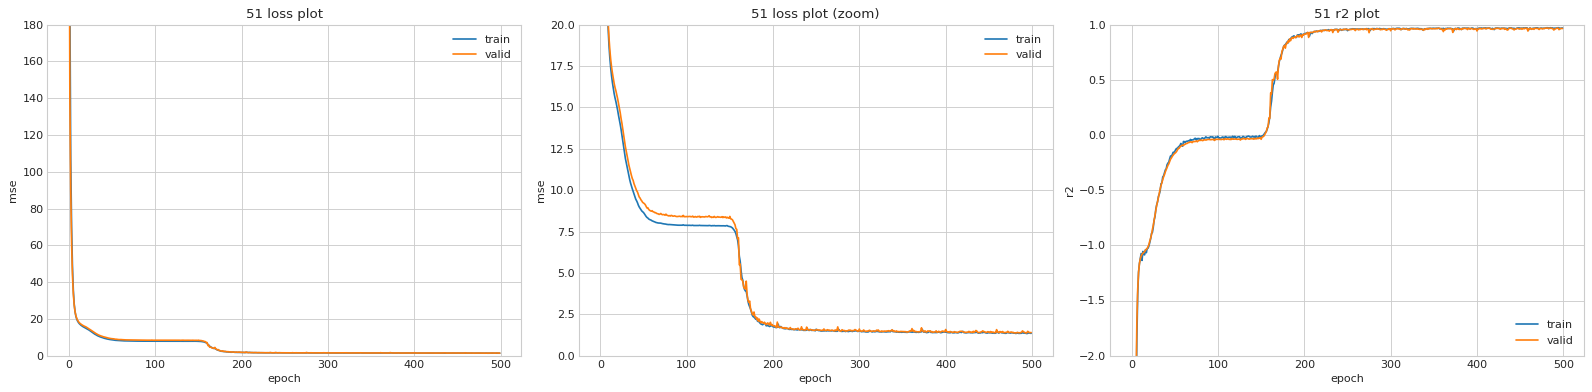

validation loss: 1.399722
validation r2: 0.964963


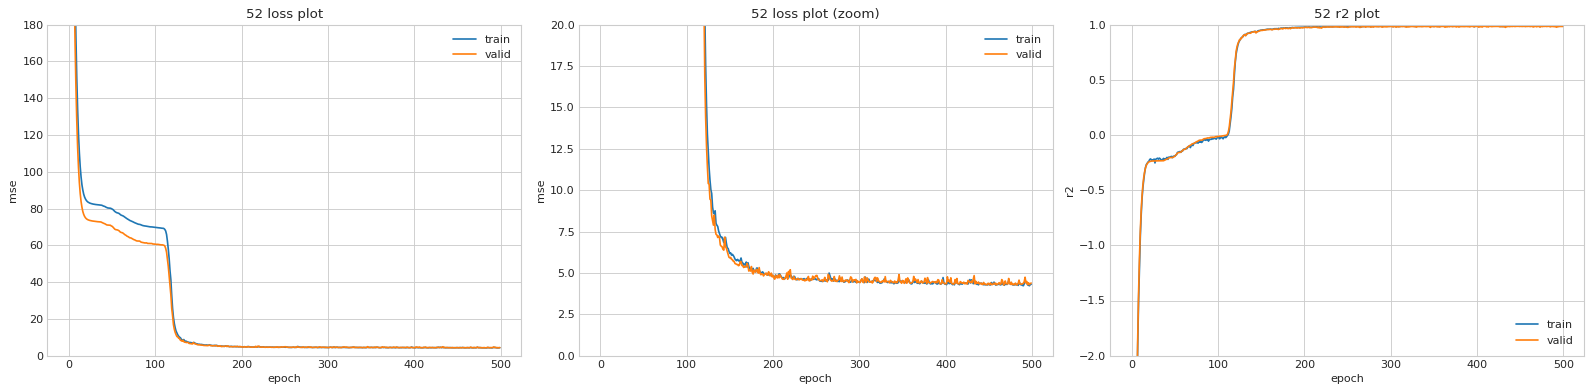

validation loss: 4.387894
validation r2: 0.983183


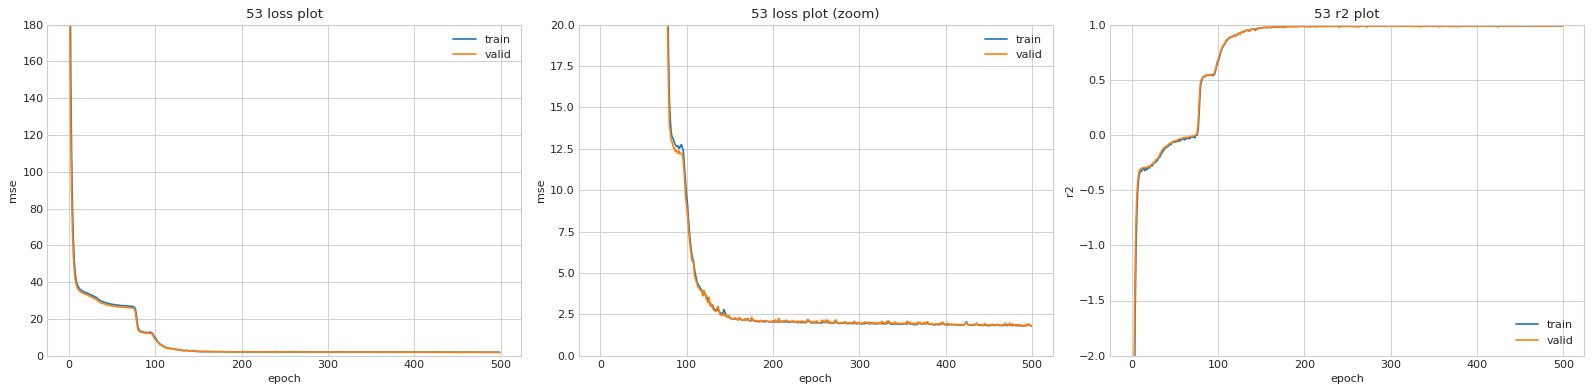

validation loss: 1.800279
validation r2: 0.989932


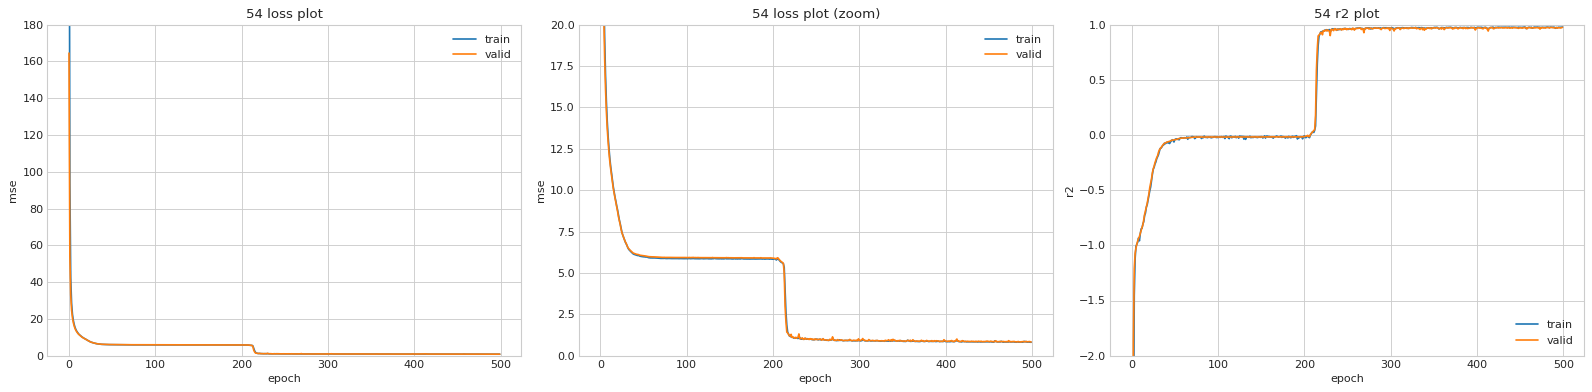

validation loss: 0.824707
validation r2: 0.975403


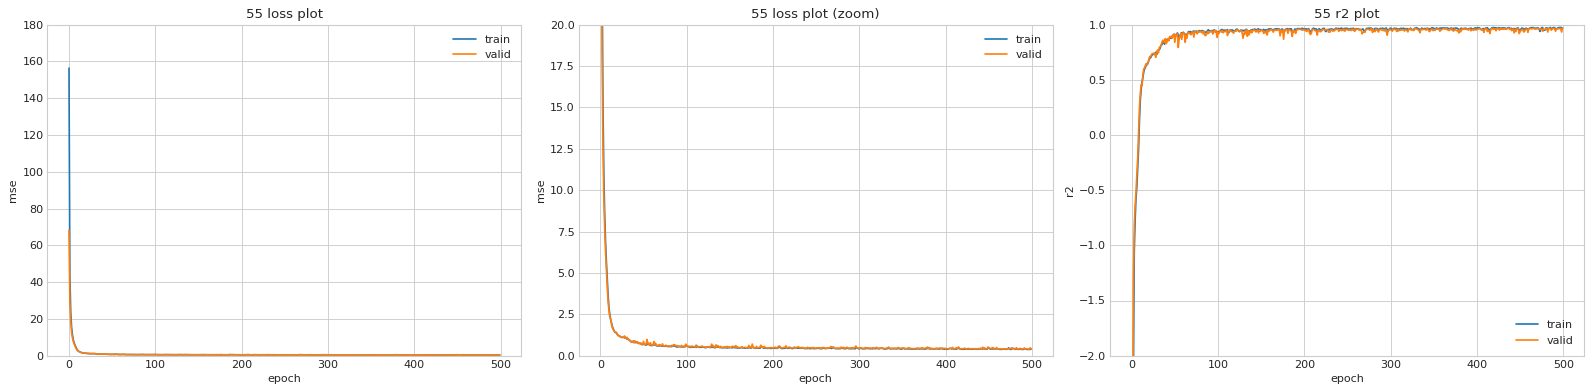

validation loss: 0.397056
validation r2: 0.966331


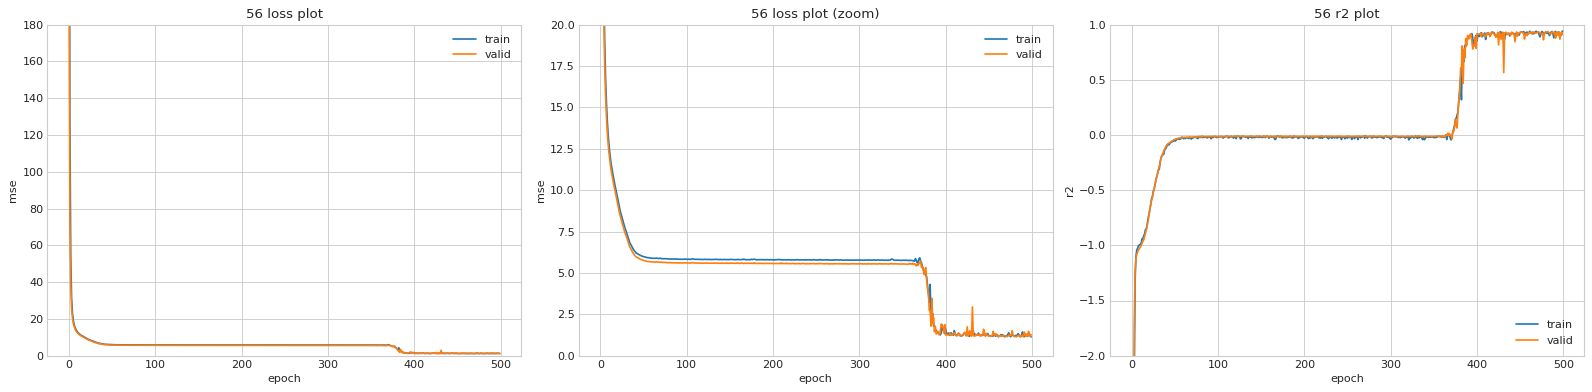

validation loss: 1.265676
validation r2: 0.911387


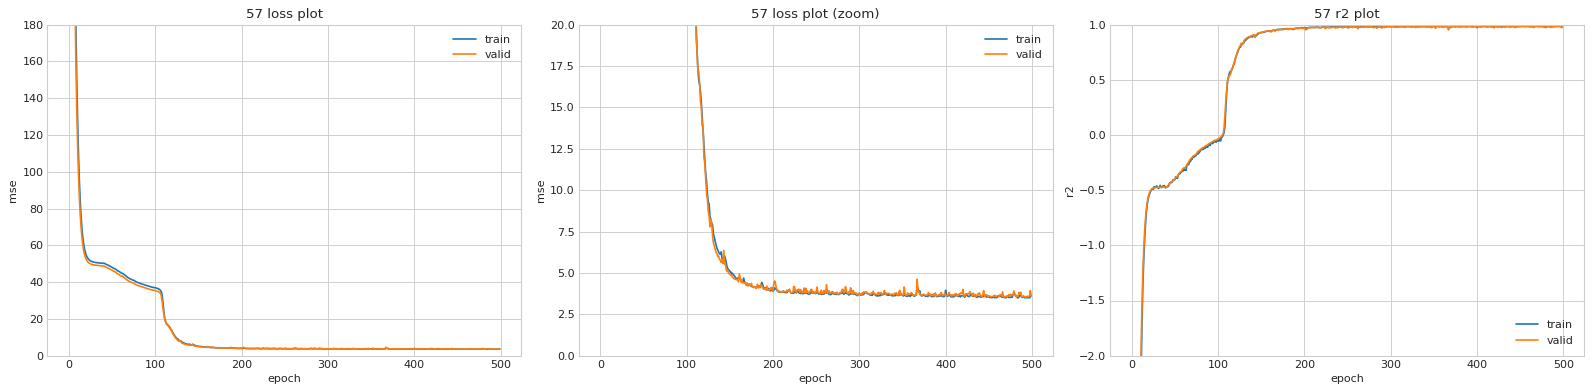

validation loss: 3.621466
validation r2: 0.981071


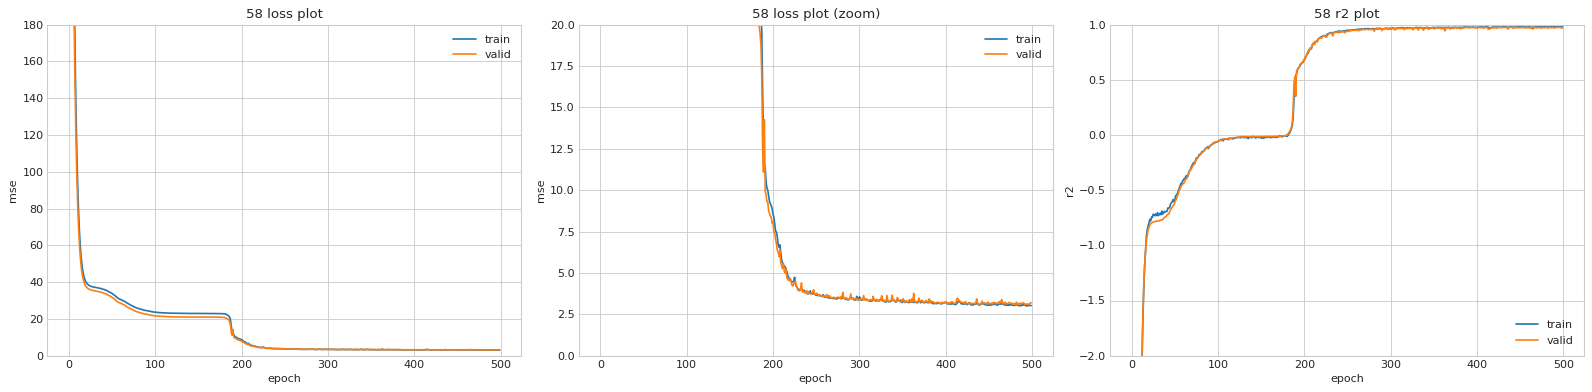

validation loss: 3.207074
validation r2: 0.969355


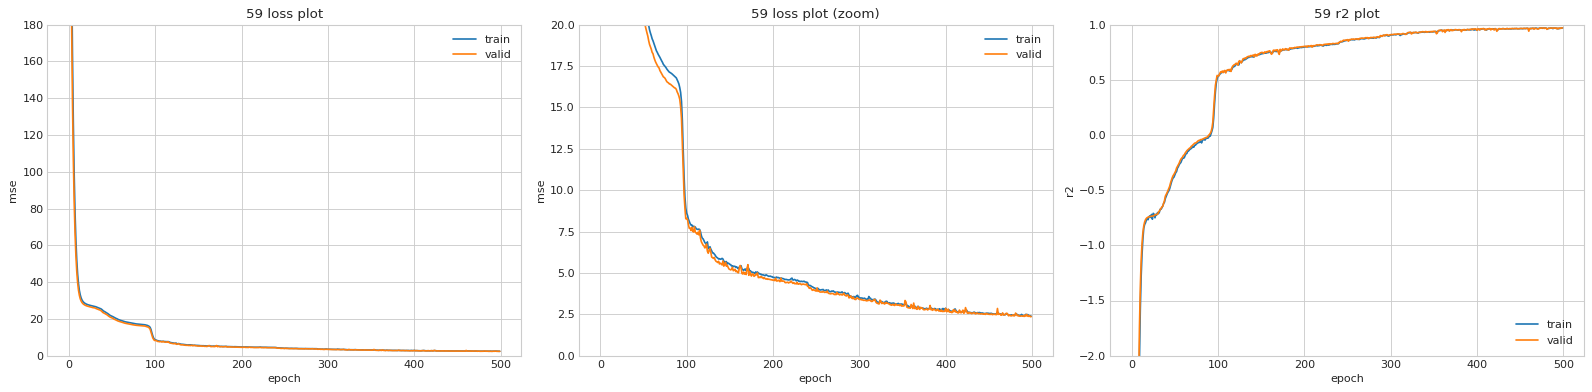

validation loss: 2.357686
validation r2: 0.970539


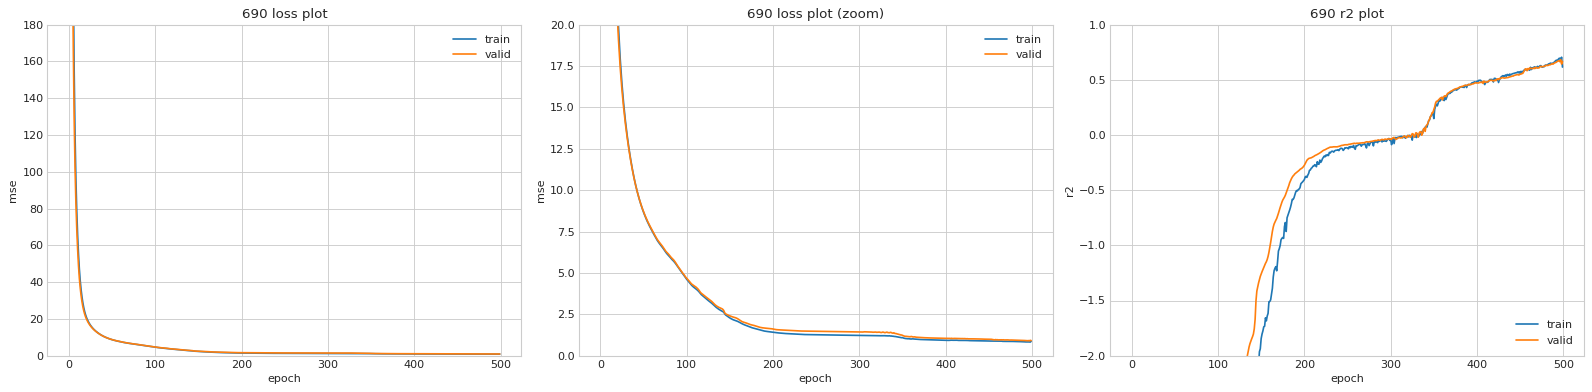

validation loss: 0.910748
validation r2: 0.666902


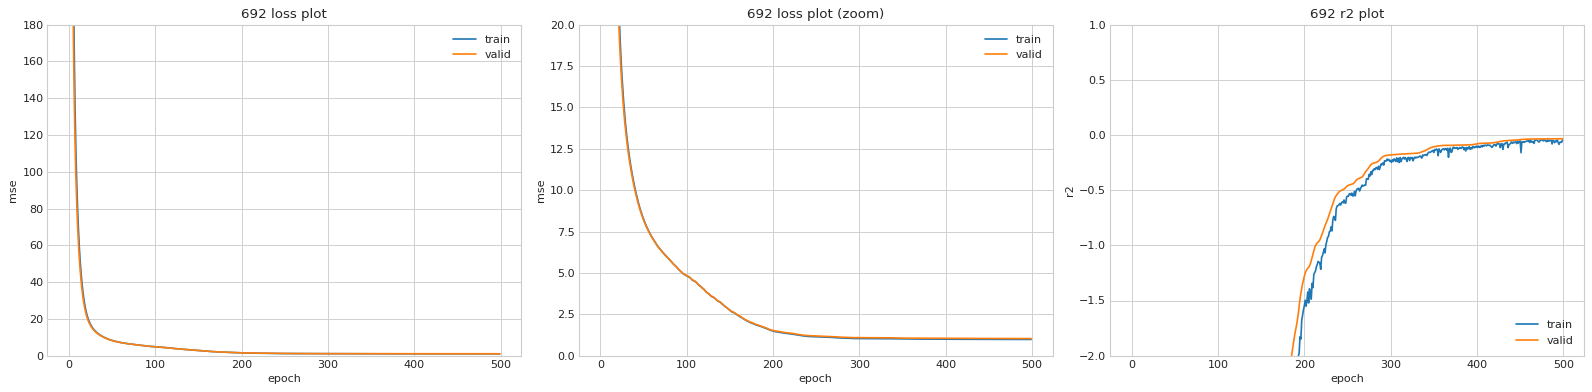

validation loss: 1.034513
validation r2: -0.033963


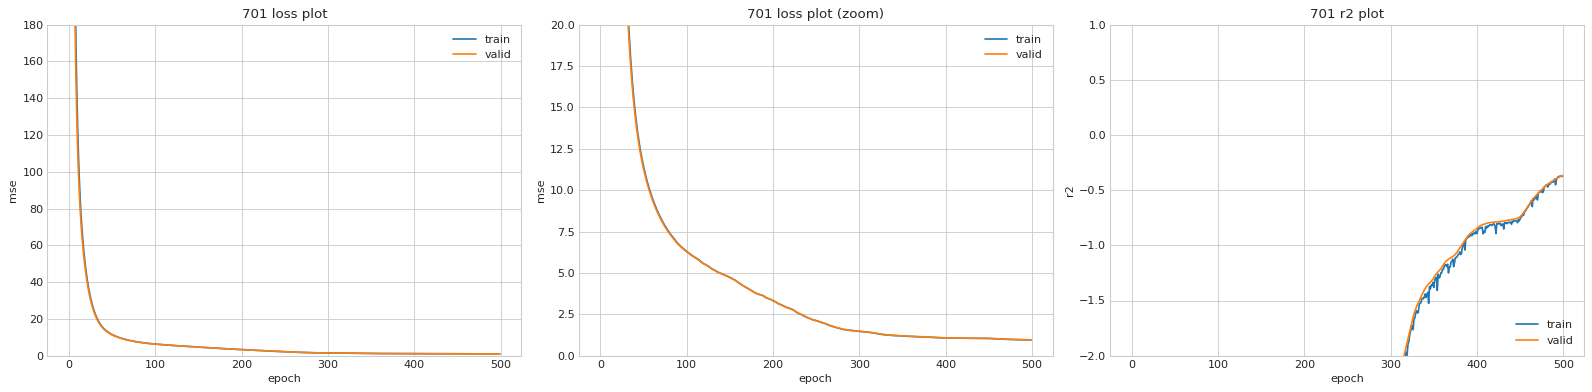

validation loss: 0.956291
validation r2: -0.366980


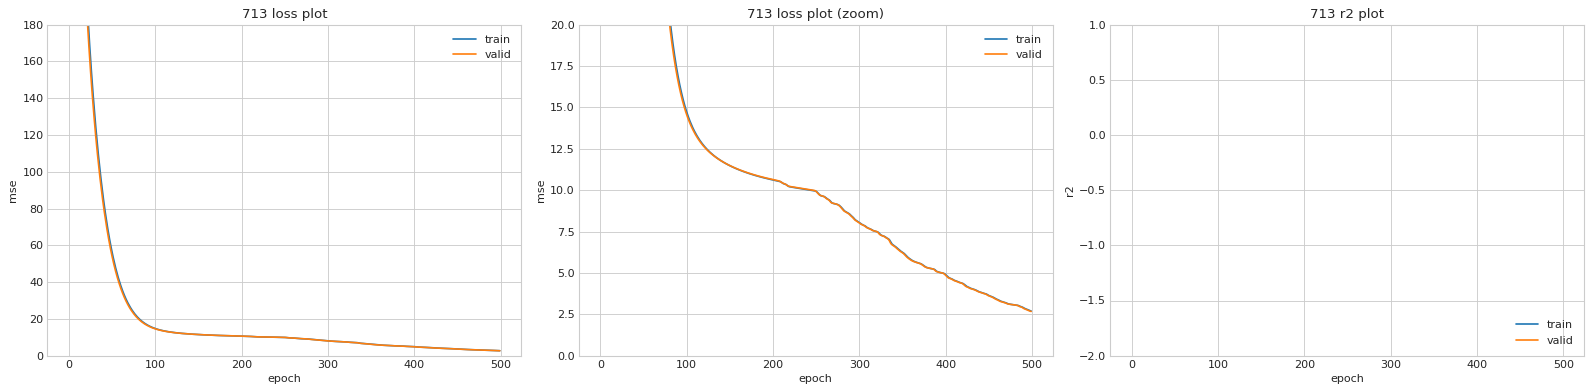

validation loss: 2.672084
validation r2: -11.317699


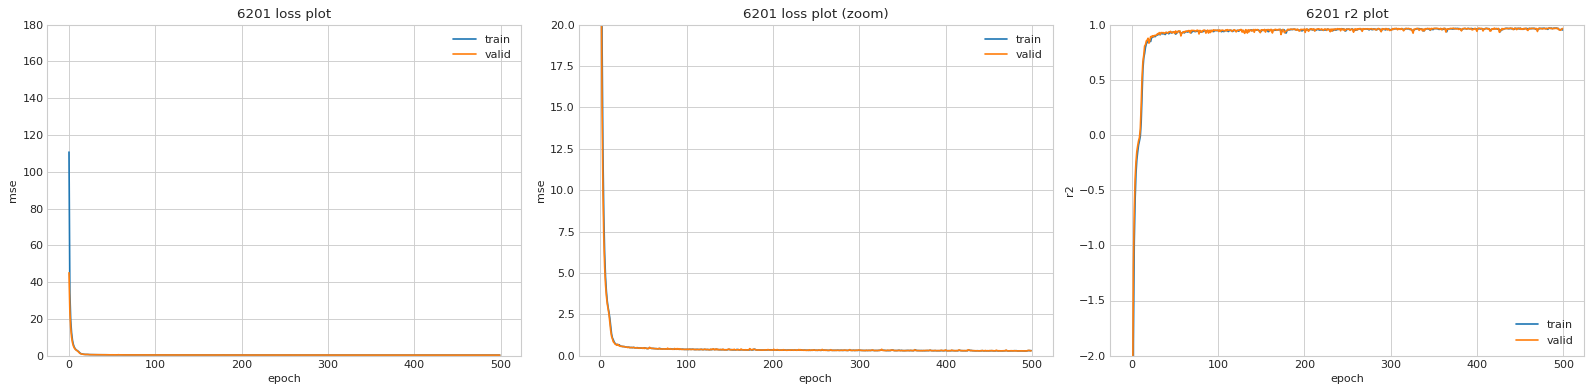

validation loss: 0.290098
validation r2: 0.965172


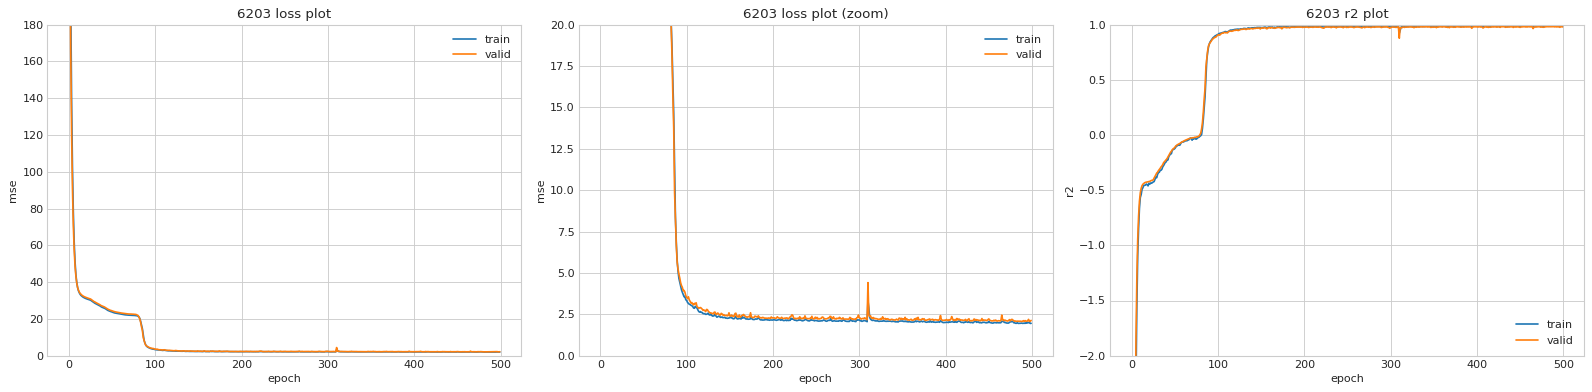

validation loss: 2.129662
validation r2: 0.979154


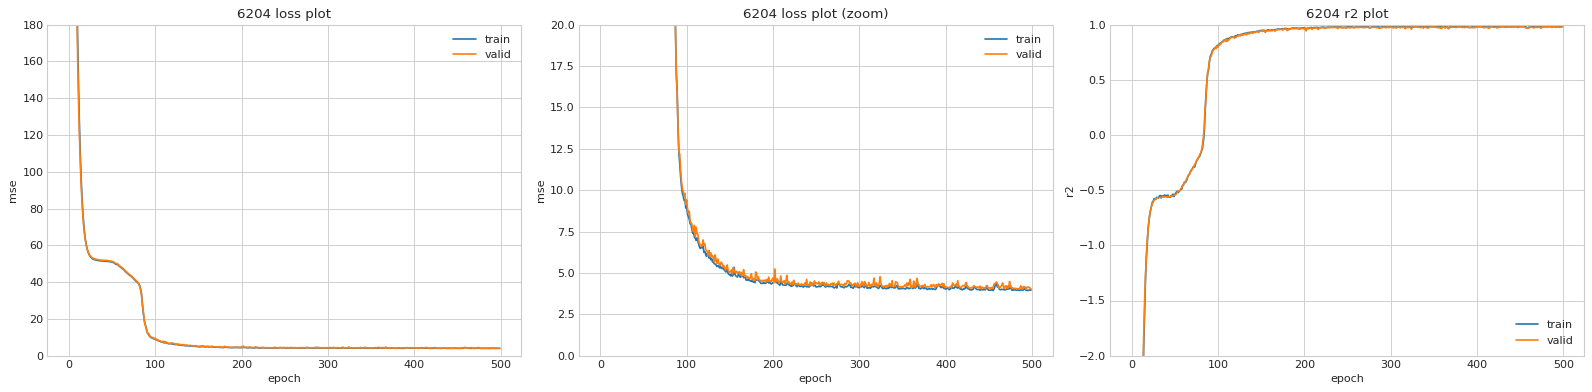

validation loss: 4.017952
validation r2: 0.980913


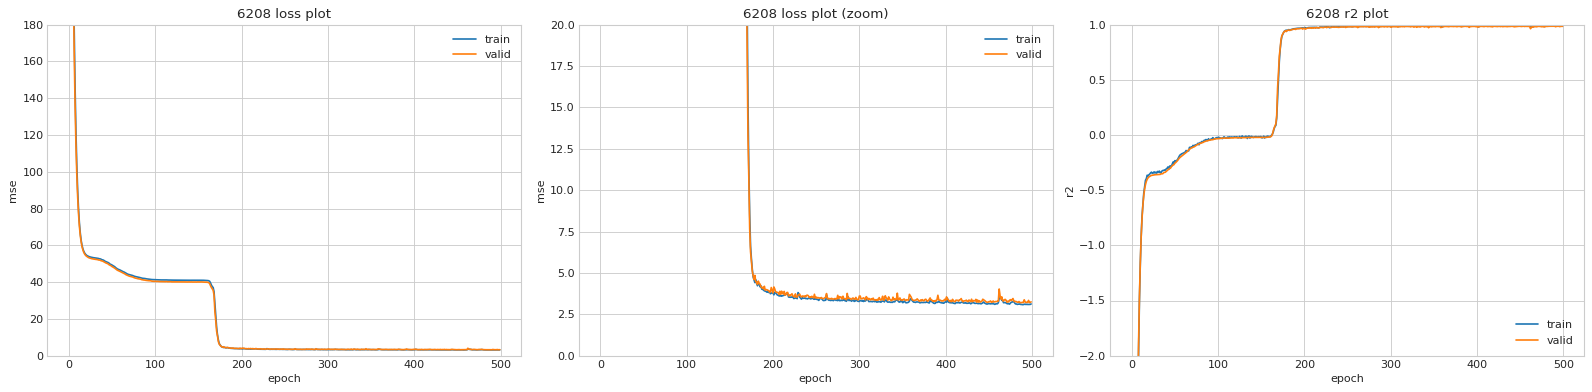

validation loss: 3.249809
validation r2: 0.984656


In [11]:
from keras.callbacks import *
from sklearn.model_selection import train_test_split
BATCH_SIZE = 64
EPOCH = 500
for model_n, (X, Y) in enumerate(train_18):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    prefix = str(codes[model_n])
    model = make_model(ts_in=TS_IN, ts_out=TS_OUT)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test) , batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=[TensorBoard(log_dir=prefix+'_logs')], shuffle=True, verbose=0)
    vis(history, title=prefix, dpi=180)
    print('validation loss: {:.6f}\nvalidation r2: {:.6f}'.format(history.history['val_loss'][-1], history.history['val_r2_keras'][-1]))
    model.save(prefix+'_model.h5')
    K.clear_session()

![](https://tbrain.trendmicro.com.tw/Content/img/18etf.png)

#### Todo:
1. Check missing data / value
2. Do more EDA on dataset
3. Try more baseline models (LSTM, GRU, CNN-1D, XGBoost, SVM, ...) 
4. Add Candlestick chart
5. Add n-fold cross validation
